## Importing Libraries

In [36]:
import os
from dotenv import load_dotenv
from graphdatascience import GraphDataScience
import pandas as pd
import matplotlib.pyplot as plt

## Load and retreive neo4j variables from .env file

In [4]:
#Storing Neo4j connection details in variables
URI = "neo4j://127.0.0.1:7687"
USER = "neo4j"
PASSWORD = "researchgrade"
DB_NAME = "neo4j"

## Initialize the Graph Data Science client

In [5]:
gds = GraphDataScience(
    URI,
    auth=(USER, PASSWORD),
    database=DB_NAME
)

In [6]:

print("Connected to Neo4j GDS server version:", gds.version())

Connected to Neo4j GDS server version: 2.25.0


In [7]:
print("Available GDS algorithms (first few rows):")
print(gds.list().head())

Available GDS algorithms (first few rows):
                                         name  \
0           gds.allShortestPaths.delta.mutate   
1  gds.allShortestPaths.delta.mutate.estimate   
2            gds.allShortestPaths.delta.stats   
3   gds.allShortestPaths.delta.stats.estimate   
4           gds.allShortestPaths.delta.stream   

                                         description  \
0  The Delta Stepping shortest path algorithm com...   
1  Returns an estimation of the memory consumptio...   
2  The Delta Stepping shortest path algorithm com...   
3  Returns an estimation of the memory consumptio...   
4  The Delta Stepping shortest path algorithm com...   

                                           signature       type  
0  gds.allShortestPaths.delta.mutate(graphName ::...  procedure  
1  gds.allShortestPaths.delta.mutate.estimate(gra...  procedure  
2  gds.allShortestPaths.delta.stats(graphName :: ...  procedure  
3  gds.allShortestPaths.delta.stats.estimate(grap...  procedu

## Graph Projections

In [8]:
# Cleanup existing graph projection if it exists
if gds.graph.exists("foodweb").exists:
    gds.graph.drop("foodweb")

In [9]:
# First projection for directed analyses (degree, betweenness, closeness, communities)
G, proj_result = gds.graph.project(
    "foodweb",
    {
        "Species": {
            "properties": []
        }
    },
    {
        "eaten_by": {
            "orientation": "NATURAL",   
            "properties": []
        }
    }
)


In [10]:
print(f"Projected {G.node_count()} nodes and {G.relationship_count()} relationships for directed analyses.\n")

Projected 1876 nodes and 1658 relationships for directed analyses.



### Write properties in the graph

a. Total Degree centrality  
b. indegree centrality
c. outdegree centrality
d. Betweeness centrality  
e. Closeness centrality  
f. Community (Louvian detection method)  
g. Strongly connected cycles


In [11]:
# Degree centrality
degree_centrality = gds.degree.write(
    G, 
    writeProperty="degree"
)

print("Degree centrality computed and written to the graph as 'degree' property.\n")

Degree centrality computed and written to the graph as 'degree' property.



In [12]:
# Betweenness centrality
betweenness_centrality = gds.betweenness.write(
    G, 
    writeProperty="betweenness"
)
print("Betweenness centrality computed and written to the graph as 'betweenness' property.\n")

Betweenness centrality computed and written to the graph as 'betweenness' property.



In [13]:
# Indegree centrality
indegree = gds.degree.write(
  G,
  orientation  = 'REVERSE',   
  writeProperty=  'inDegree'
);
print("Indegree centrality computed and written to the graph as 'inDegree' property.\n")


Indegree centrality computed and written to the graph as 'inDegree' property.



In [14]:
# Outdegree centrality
outdegree = gds.degree.write(
  G,
  orientation  = 'Natural',       
  writeProperty=  'outDegree'
);
print("Outdegree centrality computed and written to the graph as 'outDegree' property.\n")

Outdegree centrality computed and written to the graph as 'outDegree' property.



In [15]:
# Closeness centrality
closeness_centrality = gds.closeness.write(
    G, 
    writeProperty="closeness"
)

print("Closeness centrality computed and written to the graph as 'closeness' property.\n")

Closeness centrality computed and written to the graph as 'closeness' property.



In [16]:
# Using Louvain method for community detection
communities = gds.louvain.write(
    G,
    writeProperty="community"
)
print("Communities detected using Louvain method and written to the graph as 'community' property.\n")

 Louvain: 100%|██████████| 100.0/100 [00:01<00:00, 74.51%/s, status: FINISHED]                                                                   

Communities detected using Louvain method and written to the graph as 'community' property.



In [17]:
#Identify cyclic regions (SCCs)
""" This line:
- Runs the Strongly Connected Components algorithm,
- Finds cycles in your directed graph,
- Writes the component ID to each node as sccId,
- And returns a summary."""

cycles = gds.scc.write(G, writeProperty='sccId')
print("SCC IDs are written to the graph")

SCC IDs are written to the graph


## Phase 1: Analysis



In [18]:
# Analyze relationship properties
print("Analyzing relationship properties for 'eaten_by':")
props_df = gds.run_cypher("""
MATCH ()-[r:eaten_by]->()
UNWIND keys(r) AS k
RETURN k AS property, count(*) AS count
ORDER BY count DESC
""")
print(props_df)

Analyzing relationship properties for 'eaten_by':
                    property  count
0   predator_scientific_name   1658
1       prey_scientific_name   1658
2                observed_on   1658
3                  time_zone   1658
4                  image_url   1658
5                        url   1658
6         captive_cultivated   1658
7            prey_agreements   1658
8        predator_agreements   1658
9                   latitude   1657
10                 longitude   1657
11               place_state   1655
12             place_country   1655
13                     place   1652
14              place_county   1638
15       positional_accuracy   1401
16           type_of_feeding   1142
17                place_town    121


In [19]:
# Statistic summary of computed metrics 
stats_query = """
MATCH (n:Species)
RETURN 
    'Degree' as metric,
    min(n.degree) as min,
    max(n.degree) as max,
    avg(n.degree) as avg,
    count(n) as count
UNION
MATCH (n:Species)
RETURN 
    'Betweenness' as metric,
    min(n.betweenness) as min,
    max(n.betweenness) as max,
    avg(n.betweenness) as avg,
    count(n) as count
UNION
MATCH (n:Species)
RETURN 
    'Closeness' as metric,
    min(n.closeness) as min,
    max(n.closeness) as max,
    avg(n.closeness) as avg,
    count(n) as count
"""

# Run the query and get results as a pandas DataFrame
stats_df = gds.run_cypher(stats_query)

print("\nMetric Statistics:")
print(stats_df)

 Louvain: 100%|██████████| 100.0/100 [00:02<00:00, 47.85%/s, status: FINISHED]


Metric Statistics:
        metric  min    max       avg  count
0       Degree  0.0   18.0  0.883795   1876
1  Betweenness  0.0  279.0  0.535181   1876
2    Closeness  0.0    1.0  0.488804   1876


In [20]:
# Query to retrieve calculated metrics for each node
# Top 10 species by betweenness centrality
betweeness_query = """
MATCH (n:Species)
RETURN n.common_name as common_name,
       n.scientific_name as scientific_name,
       n.betweenness as betweenness,
       n.community as community
ORDER BY n.betweenness DESC
LIMIT 10
"""

# Run the query and get results as a pandas DataFrame
betweeness_df = gds.run_cypher(betweeness_query)

print("\nTop 10 species by betweenness centrality:")
print(betweeness_df)


Top 10 species by betweenness centrality:
             common_name              scientific_name  betweenness  community
0      Western Honey Bee               Apis mellifera        279.0       1092
1              Siam weed          Chromolaena odorata         84.0       1428
2   Western Yellowjacket         Vespula pensylvanica         60.0       1092
3   Common Dotted Border  Mylothris agathina agathina         52.0       1428
4          Dancing Amber             Telchinia serena         35.0       1428
5       Eastern Pondhawk     Erythemis simplicicollis         33.0       1591
6  American Red Squirrel      Tamiasciurus hudsonicus         32.0        216
7         American Robin           Turdus migratorius         30.0        216
8                   None       Globimetula mweroensis         24.0       1428
9           European Eel            Anguilla anguilla         24.0        921


In [21]:
# Top 10 species by degree centrality
degree_query = """
MATCH (n:Species)
RETURN n.common_name as common_name,
       n.scientific_name as scientific_name,
       n.degree as degree,
       n.community as community
ORDER BY n.degree DESC
LIMIT 10
"""

# Run the query and get results as a pandas DataFrame
degree_df = gds.run_cypher(degree_query)

print("\nTop 10 species by degree centrality:")
print(degree_df)


Top 10 species by degree centrality:
          common_name            scientific_name  degree  community
0     Common Wild Fig               Ficus burkei    18.0        726
1  American persimmon       Diospyros virginiana    15.0       1431
2     Yellow Justicia             Justicia flava    15.0       1428
3   Western Honey Bee             Apis mellifera     9.0       1092
4        Duiker-berry  Sclerocroton integerrimus     9.0       1419
5    creeping thistle            Cirsium arvense     9.0       1591
6      Natal Bluehaze     Tetraselago natalensis     9.0       1428
7  Broom Sycamore Fig  Ficus sycomorus sycomorus     8.0        726
8   Coastal Resintree     Ozoroa obovata obovata     8.0       1092
9            Cape Fig                  Ficus sur     8.0        726


In [72]:
# Top 10 species by indegree centrality
indegree_query = """
MATCH (n:Species)
RETURN n.common_name as common_name,
       n.scientific_name as scientific_name,
       n.inDegree as Indegree,
       n.degree as Total_degree
ORDER BY n.inDegree DESC
"""

# Run the query and get results as a pandas DataFrame
indegree_df = gds.run_cypher(indegree_query)

print("\nTop 10 species by indegree centrality:")
print(indegree_df.head(10))


Top 10 species by indegree centrality:
                        common_name                   scientific_name  \
0                 Western Honey Bee                    Apis mellifera   
1                  Great Blue Heron                    Ardea herodias   
2                      Olympic Gull  Larus glaucescens × occidentalis   
3                            Osprey                 Pandion haliaetus   
4              Glaucous-winged Gull                 Larus glaucescens   
5  Southern Brown-hooded Kingfisher   Halcyon albiventris albiventris   
6             Margined Calligrapher              Toxomerus marginatus   
7                        Grey Heron                     Ardea cinerea   
8                        Bald Eagle          Haliaeetus leucocephalus   
9                     Cooper's Hawk                    Astur cooperii   

   Indegree  Total_degree  
0      29.0           9.0  
1      29.0           0.0  
2      15.0           0.0  
3      15.0           1.0  
4      14.0     

In [73]:
# Top 10 species by outdegree centrality
outdegree_query = """
MATCH (n:Species)
RETURN n.common_name as common_name,
       n.scientific_name as scientific_name,
       n.outDegree as Outdegree,
       n.degree as Total_degree
ORDER BY n.outDegree DESC
"""

# Run the query and get results as a pandas DataFrame
outdegree_df = gds.run_cypher(outdegree_query)

print("\nTop 10 species by outdegree centrality:")
print(outdegree_df.head(10))


Top 10 species by outdegree centrality:
          common_name            scientific_name  Outdegree  Total_degree
0     Common Wild Fig               Ficus burkei       18.0          18.0
1  American persimmon       Diospyros virginiana       15.0          15.0
2     Yellow Justicia             Justicia flava       15.0          15.0
3   Western Honey Bee             Apis mellifera        9.0           9.0
4    creeping thistle            Cirsium arvense        9.0           9.0
5        Duiker-berry  Sclerocroton integerrimus        9.0           9.0
6      Natal Bluehaze     Tetraselago natalensis        9.0           9.0
7   Coastal Resintree     Ozoroa obovata obovata        8.0           8.0
8        Tridax Daisy          Tridax procumbens        8.0           8.0
9      Scrambling Fig          Ficus burtt-davyi        8.0           8.0


In [76]:
# Calculate total indegree and total outdegree
total_in_degree = indegree_df['Indegree'].sum()
total_out_degree = outdegree_df['Outdegree'].sum()

# Number of nodes is the number of species
number_of_nodes = len(indegree_df)

# Calculate average degree, average outdegree, and average indegree
average_degree = (total_in_degree + total_out_degree) / number_of_nodes
average_indegree = total_in_degree / number_of_nodes
average_outdegree = total_out_degree / number_of_nodes

print(f"Average Degree: {average_degree}")
print(f"Average Indegree: {average_indegree}")
print(f"Average Outdegree: {average_outdegree}")

Average Degree: 1.767590618336887
Average Indegree: 0.8837953091684435
Average Outdegree: 0.8837953091684435


In [24]:
# Top 10 species by closeness centrality
closeness_query = """
MATCH (n:Species)
RETURN n.common_name as common_name,
       n.scientific_name as scientific_name,
       n.closeness as closeness,
       n.community as community
ORDER BY n.closeness DESC
LIMIT 840
"""

# Run the query and get results as a pandas DataFrame
closeness_df = gds.run_cypher(closeness_query)

print("\nTop 10 species by closeness centrality:")
print(closeness_df)


Top 10 species by closeness centrality:
                         common_name                   scientific_name  \
0                        False Chief              Pseudacraea lucretia   
1               African Veined White  Pseudanaphaeis gidica abyssinica   
2               Green Cape White-eye           Zosterops virens virens   
3    Eastern Clouded Mother-of-Pearl         Protogoniomorpha nebulosa   
4                    Six-spot Burnet              Zygaena filipendulae   
..                               ...                               ...   
835    Gray Treefrog Species Complex                   Hyla versicolor   
836                 Great Blue Heron                    Ardea herodias   
837                     Olympic Gull  Larus glaucescens × occidentalis   
838      Southern Dark-capped Bulbul       Pycnonotus barbatus layardi   
839      Southern Dark-capped Bulbul               Pycnonotus barbatus   

     closeness  community  
0     1.000000       1425  
1     1.000000

## Finding long chains using APOC path expansion

In [34]:
# This Cypher query is designed to find long chains of relationships in a graph database.
# Specifically, it identifies paths in the graph where nodes are connected by the 'eaten_by' relationship.

long_chain = """
MATCH (s:Species)
CALL apoc.path.expandConfig(s, {
  relationshipFilter: '<eaten_by',
  minLevel: 1,
  maxLevel: 50,
  uniqueness: 'NODE_GLOBAL',
  bfs: false,
  limit: 100000
}) YIELD path
WITH path, length(path)+1 AS len
RETURN apoc.text.join([n IN nodes(path) | n.scientific_name], ' -> ') AS chain, len 
ORDER BY len DESC

"""

long_chain_df = gds.run_cypher(long_chain)
print("\nTop 10 longest food chains found:")
print(long_chain_df)
long_chain_df.to_csv("Data/long_food_chains.csv", index=False)


Top 10 longest food chains found:
                                                  chain  len
0     Pantherophis spiloides -> Strix varia -> Tamia...    6
1     Lippia javanica -> Mylothris agathina agathina...    5
2     Lippia javanica -> Mylothris agathina agathina...    5
3     Lippia javanica -> Mylothris agathina agathina...    5
4     Lippia javanica -> Mylothris agathina agathina...    5
...                                                 ...  ...
2374      Halichoerus grypus atlantica -> Conger conger    2
2375          Halictus confusus -> Convolvulus arvensis    2
2376      Halysidota tessellaris -> Celtis occidentalis    2
2377        Halysidota tessellaris -> Fagus grandifolia    2
2378         Hedydipna collaris -> Erythrina lysistemon    2

[2379 rows x 2 columns]


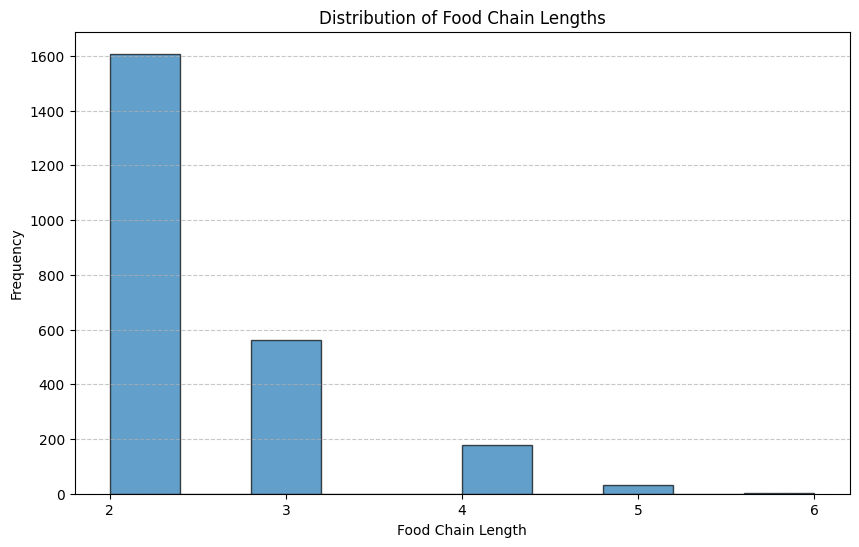

In [58]:

# Plot the distribution of food chain lengths
plt.figure(figsize=(10, 6))
long_chain_df['len'].plot(kind='hist', bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Food Chain Lengths')
plt.xlabel('Food Chain Length')
plt.xticks(range(int(long_chain_df['len'].min()), int(long_chain_df['len'].max()) + 1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [69]:
# Cypher query to calculate connectance
connectance_query = """
MATCH (n:Species)
WITH count(DISTINCT n) AS total_nodes
MATCH ()-[r:eaten_by]->()
WITH total_nodes, count(r) AS total_links
RETURN total_links AS actual_links, 
    total_nodes * (total_nodes - 1) AS possible_links, 
    toFloat(total_links) / (total_nodes * (total_nodes - 1)) AS connectance
"""

# Run the query and get results as a pandas DataFrame
connectance_df = gds.run_cypher(connectance_query)

print("\nConnectance of the graph:")
print(connectance_df)


Connectance of the graph:
   actual_links  possible_links  connectance
0          1658         3517500     0.000471


In [ ]:

# Cypher query to calculate average clustering coefficient for the graph
clustering_query = """
MATCH (n:Species)
OPTIONAL MATCH (n)-[:eaten_by]-(neighbor)
WITH n, count(DISTINCT neighbor) AS degree
WHERE degree > 1
OPTIONAL MATCH (n)-[:eaten_by]-(neighbor1)-[:eaten_by]-(neighbor2)-[:eaten_by]-(n)
WHERE neighbor1 <> neighbor2
WITH n, degree, count(DISTINCT neighbor1) AS triangles
RETURN avg(toFloat(triangles) / (degree * (degree - 1))) AS average_clustering
"""

# Run the query and get results as a pandas DataFrame
clustering_df = gds.run_cypher(clustering_query)

print("\nAverage Clustering Coefficient of the graph:")
print(clustering_df)


ClientError: {code: Neo.ClientError.Statement.ArithmeticError} {message: / by zero}

In [65]:
# Query to display cycles (SCCs) in the graph
display_cycles = """
MATCH (n:Species)
WITH n.sccId AS scc, count(*) AS size
WHERE size > 1
RETURN scc, size
ORDER BY size DESC
"""
length_cycles_df = gds.run_cypher(display_cycles)
print("\nCycles:")
print(length_cycles_df)


Cycles:
     scc  size
0    243     6
1    103     3
2      6     2
3    139     2
4    195     2
5    228     2
6    264     2
7    733     2
8    881     2
9    964     2
10  1135     2


In [68]:
# Query to find 50 cyclic chains within a specified SCC ID
cyclic_chains="""
MATCH (start:Species {sccId: $sccId})
CALL apoc.path.expandConfig(start, {
  relationshipFilter: '<eaten_by',
  minLevel: 2,
  maxLevel: 12,
  filterStartNode: true,
  where: 'node.sccId = startNode.sccId',
  terminatorNodes: [start],
  limit: 100000
}) YIELD path
WHERE last(nodes(path)) = start
WITH path, length(path) AS len, $sccId AS sccId
RETURN [n IN nodes(path) | n.scientific_name] AS scientific_names, len, sccId
ORDER BY len DESC
"""

cyclic_chains_df = gds.run_cypher(cyclic_chains,{"sccId": 243})
print("\nCycles:")
print(cyclic_chains_df)



Cycles:
                                      scientific_names  len  sccId
0    [Belenois creona severina, Chromolaena odorata...   10    243
1    [Belenois creona severina, Chromolaena odorata...   10    243
2    [Belenois creona severina, Chromolaena odorata...   10    243
3    [Belenois creona severina, Chromolaena odorata...   10    243
4    [Belenois creona severina, Chromolaena odorata...   10    243
..                                                 ...  ...    ...
115  [Delta fenestrale, Chromolaena odorata, Delta ...    2    243
116  [Lippia javanica, Mylothris agathina agathina,...    2    243
117  [Mylothris agathina agathina, Chromolaena odor...    2    243
118  [Mylothris agathina agathina, Lippia javanica,...    2    243
119  [Telchinia serena, Chromolaena odorata, Telchi...    2    243

[120 rows x 3 columns]
